In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [105]:
import sys

# sys.path.append(f'{base_dir}/github_repos')
sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, decomposition, h5_handling, plotting_helpers, indexing
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import unlabeled training data

In [4]:
data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

toss any NaNs

In [5]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


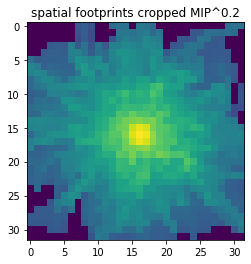

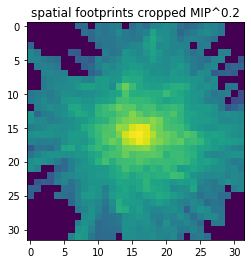

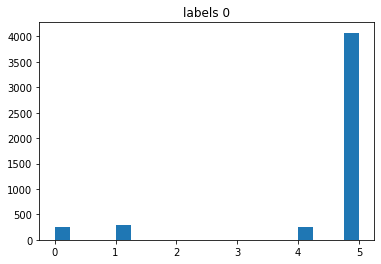

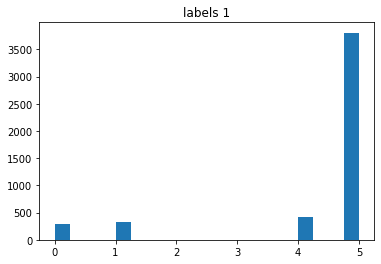

In [6]:
# dir_folders = f'{base_dir}/label_data'
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

<IPython.core.display.Javascript object>


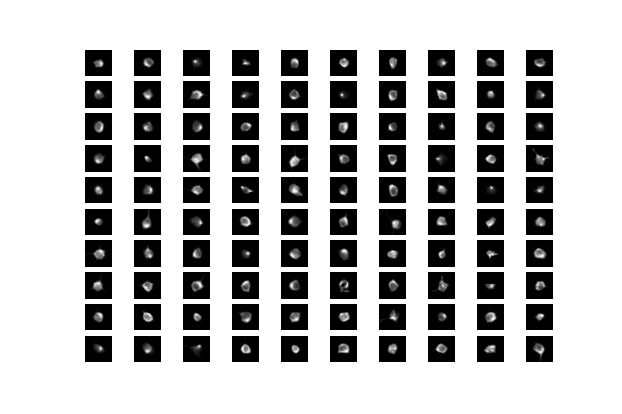

In [7]:
%matplotlib notebook

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [8]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [9]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [10]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

<IPython.core.display.Javascript object>


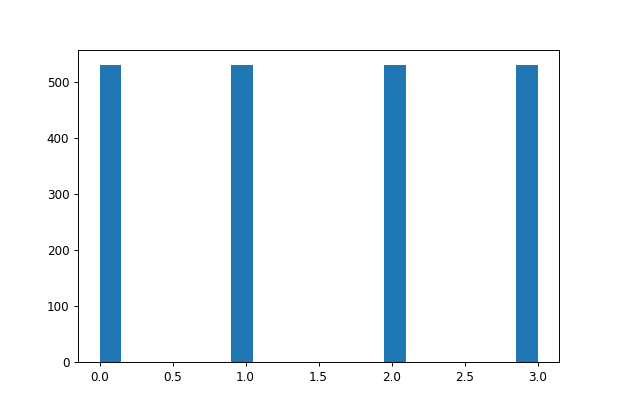

In [11]:
plt.figure()
plt.hist(labels_dup, 20);

In [12]:
images.shape

(2128, 32, 32)

# Train

In [13]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [14]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [15]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [16]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [17]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [18]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [19]:
# unfreeze particular blocks in ResNet model

for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 6:
            param.requires_grad = False
        elif int(name[11]) >= 6:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

base_model.6.0.conv1.weight
base_model.6.0.bn1.weight
base_model.6.0.bn1.bias
base_model.6.0.conv2.weight
base_model.6.0.bn2.weight
base_model.6.0.bn2.bias
base_model.6.0.downsample.0.weight
base_model.6.0.downsample.1.weight
base_model.6.0.downsample.1.bias
base_model.6.1.conv1.weight
base_model.6.1.bn1.weight
base_model.6.1.bn1.bias
base_model.6.1.conv2.weight
base_model.6.1.bn2.weight
base_model.6.1.bn2.bias
base_model.7.0.conv1.weight
base_model.7.0.bn1.weight
base_model.7.0.bn1.bias
base_model.7.0.conv2.weight
base_model.7.0.bn2.weight
base_model.7.0.bn2.bias
base_model.7.0.downsample.0.weight
base_model.7.0.downsample.1.weight
base_model.7.0.downsample.1.bias
base_model.7.1.conv1.weight
base_model.7.1.bn1.weight
base_model.7.1.bn1.bias
base_model.7.1.conv2.weight
base_model.7.1.bn2.weight
base_model.7.1.bn2.bias
PreHead_0.weight
PreHead_0.bias
PreHead_1.weight
PreHead_1.bias
PostHead_0.weight
PostHead_0.bias
Classifier_0.weight
Classifier_0.bias


## Define augmentation pipeline

In [22]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
#     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
#         torchvision.transforms.RandomPerspective(distortion_scale=0.7, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.1)),
        

    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.2, 0.2),
                                        scale=(0.4, 1.3), 
                                        shear=(-25, 25, -25, 25), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(4.0), 10**(6.)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.0002,
                                    prob=1),
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(1.5), 10**(4.0)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.1,
                                    prob=1),
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),

#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.0, 0.0),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         # fillcolor=None, 
#                                         resample=None),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms

In [21]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

<IPython.core.display.Javascript object>


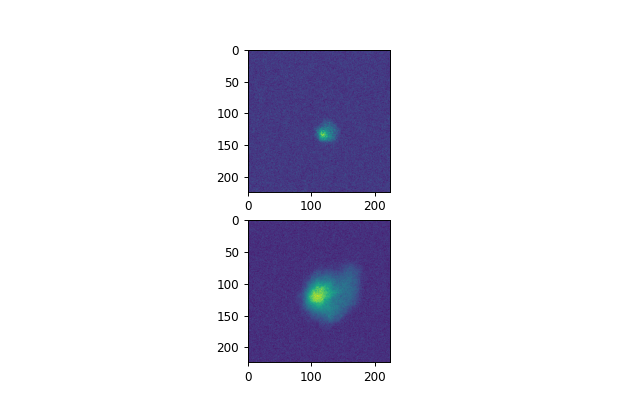

<IPython.core.display.Javascript object>


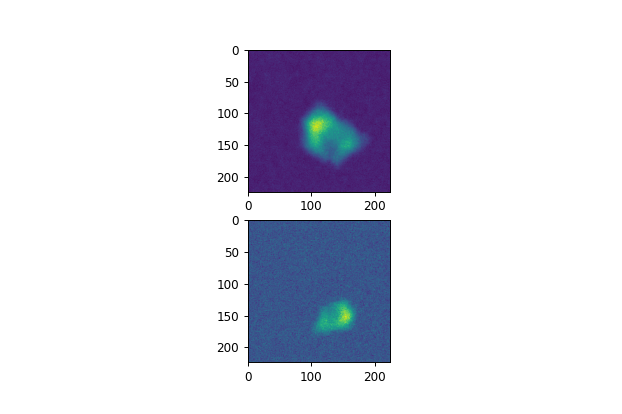

<IPython.core.display.Javascript object>


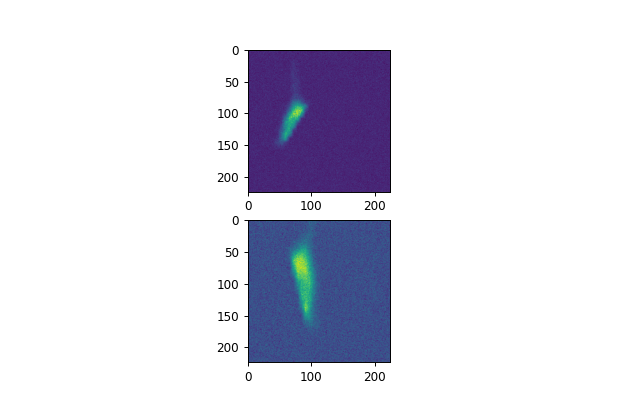

<IPython.core.display.Javascript object>


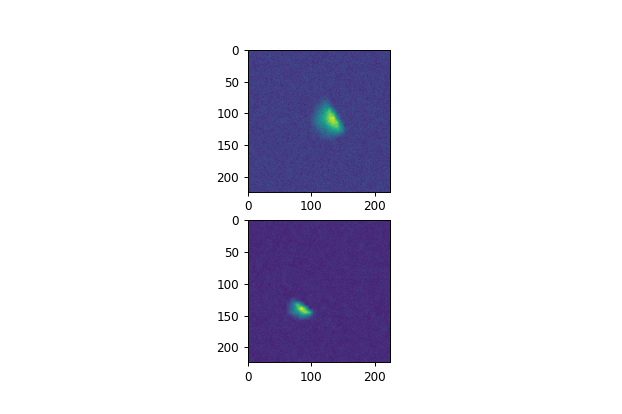

<IPython.core.display.Javascript object>


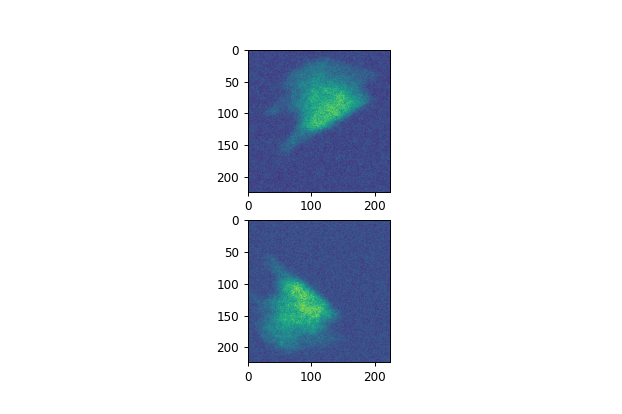

<IPython.core.display.Javascript object>


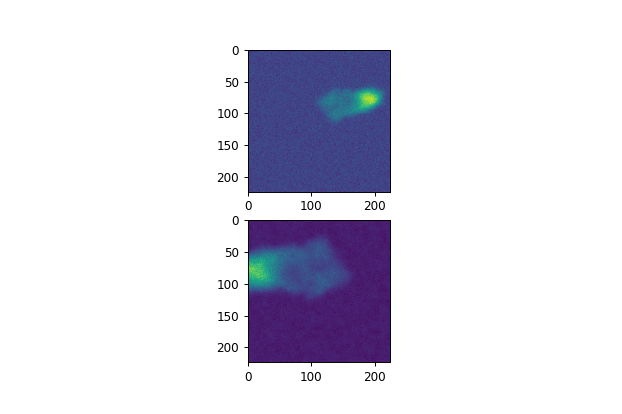

<IPython.core.display.Javascript object>


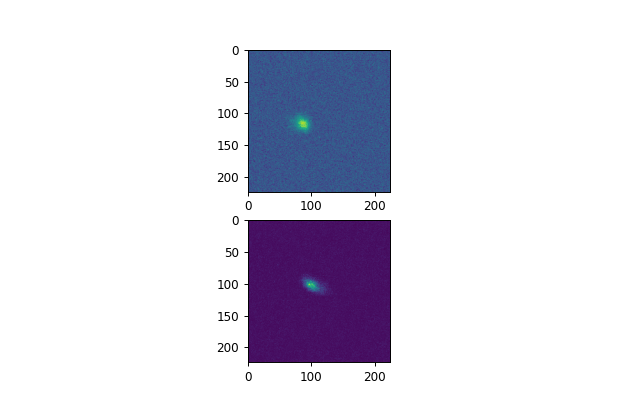

<IPython.core.display.Javascript object>


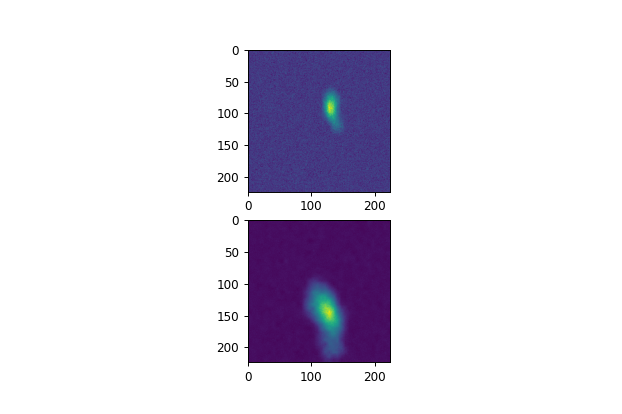

<IPython.core.display.Javascript object>


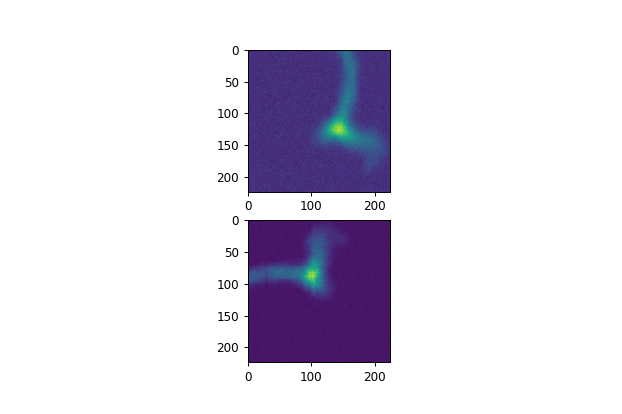

<IPython.core.display.Javascript object>


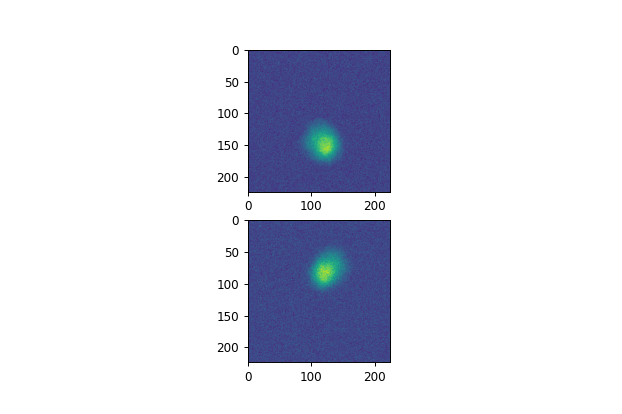

In [22]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [23]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [24]:
model.to(DEVICE)
model.prep_contrast()

In [25]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [26]:
l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=20,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

epoch: 0
Iter: 0/695, loss_train: 7.6125, loss_val: nan, pos_over_neg: 1.0138496160507202 lr: 0.001
Iter: 20/695, loss_train: 6.4966, loss_val: nan, pos_over_neg: 55.472816467285156 lr: 0.001
Iter: 40/695, loss_train: 6.3826, loss_val: nan, pos_over_neg: 79.61542510986328 lr: 0.001
Iter: 60/695, loss_train: 6.3029, loss_val: nan, pos_over_neg: 448.611572265625 lr: 0.001
Iter: 80/695, loss_train: 6.2563, loss_val: nan, pos_over_neg: 347.0462951660156 lr: 0.001
Iter: 100/695, loss_train: 6.1969, loss_val: nan, pos_over_neg: 120.95177459716797 lr: 0.001
Iter: 120/695, loss_train: 6.1462, loss_val: nan, pos_over_neg: 383.51031494140625 lr: 0.001
Iter: 140/695, loss_train: 6.1137, loss_val: nan, pos_over_neg: 135.17462158203125 lr: 0.001
Iter: 160/695, loss_train: 6.1102, loss_val: nan, pos_over_neg: 411.55401611328125 lr: 0.001
Iter: 180/695, loss_train: 6.1243, loss_val: nan, pos_over_neg: 143.83865356445312 lr: 0.001
Iter: 200/695, loss_train: 6.1027, loss_val: nan, pos_over_neg: 484.938

Iter: 380/695, loss_train: 5.9359, loss_val: nan, pos_over_neg: 426.49261474609375 lr: 0.001
Iter: 400/695, loss_train: 5.9367, loss_val: nan, pos_over_neg: 344.51556396484375 lr: 0.001
Iter: 420/695, loss_train: 5.9338, loss_val: nan, pos_over_neg: 247.2957305908203 lr: 0.001
Iter: 440/695, loss_train: 5.9309, loss_val: nan, pos_over_neg: 667.2597045898438 lr: 0.001
Iter: 460/695, loss_train: 5.9335, loss_val: nan, pos_over_neg: 250.69371032714844 lr: 0.001
Iter: 480/695, loss_train: 5.9384, loss_val: nan, pos_over_neg: 869.3319091796875 lr: 0.001
Iter: 500/695, loss_train: 5.9283, loss_val: nan, pos_over_neg: 341.8553771972656 lr: 0.001
Iter: 520/695, loss_train: 5.9287, loss_val: nan, pos_over_neg: 674.1700439453125 lr: 0.001
Iter: 540/695, loss_train: 5.9243, loss_val: nan, pos_over_neg: 602.1587524414062 lr: 0.001
Iter: 560/695, loss_train: 5.9194, loss_val: nan, pos_over_neg: 502.8816833496094 lr: 0.001
Iter: 580/695, loss_train: 5.9254, loss_val: nan, pos_over_neg: 939.210021972

Iter: 80/695, loss_train: 5.8866, loss_val: nan, pos_over_neg: 955.2890625 lr: 0.001
Iter: 100/695, loss_train: 5.8962, loss_val: nan, pos_over_neg: 1207.1932373046875 lr: 0.001
Iter: 120/695, loss_train: 5.91, loss_val: nan, pos_over_neg: 626.5242309570312 lr: 0.001
Iter: 140/695, loss_train: 5.9002, loss_val: nan, pos_over_neg: 632.3695068359375 lr: 0.001
Iter: 160/695, loss_train: 5.901, loss_val: nan, pos_over_neg: 729.432861328125 lr: 0.001
Iter: 180/695, loss_train: 5.8944, loss_val: nan, pos_over_neg: 1233.005126953125 lr: 0.001
Iter: 200/695, loss_train: 5.9032, loss_val: nan, pos_over_neg: 681.904541015625 lr: 0.001
Iter: 220/695, loss_train: 5.8967, loss_val: nan, pos_over_neg: 788.0028076171875 lr: 0.001
Iter: 240/695, loss_train: 5.9011, loss_val: nan, pos_over_neg: 762.1265258789062 lr: 0.001
Iter: 260/695, loss_train: 5.8962, loss_val: nan, pos_over_neg: 358.8295593261719 lr: 0.001
Iter: 280/695, loss_train: 5.9262, loss_val: nan, pos_over_neg: 458.64306640625 lr: 0.001
I

Iter: 480/695, loss_train: 5.8801, loss_val: nan, pos_over_neg: 1591.25 lr: 0.001
Iter: 500/695, loss_train: 5.8743, loss_val: nan, pos_over_neg: 1436.6715087890625 lr: 0.001
Iter: 520/695, loss_train: 5.8842, loss_val: nan, pos_over_neg: 724.739990234375 lr: 0.001
Iter: 540/695, loss_train: 5.8753, loss_val: nan, pos_over_neg: 853.5850219726562 lr: 0.001
Iter: 560/695, loss_train: 5.8722, loss_val: nan, pos_over_neg: 900.4164428710938 lr: 0.001
Iter: 580/695, loss_train: 5.88, loss_val: nan, pos_over_neg: 685.866455078125 lr: 0.001
Iter: 600/695, loss_train: 5.8872, loss_val: nan, pos_over_neg: 819.6082153320312 lr: 0.001
Iter: 620/695, loss_train: 5.9024, loss_val: nan, pos_over_neg: 795.0011596679688 lr: 0.001
Iter: 640/695, loss_train: 5.8917, loss_val: nan, pos_over_neg: 592.6165771484375 lr: 0.001
Iter: 660/695, loss_train: 5.8992, loss_val: nan, pos_over_neg: 326.3266296386719 lr: 0.001
Iter: 680/695, loss_train: 5.8806, loss_val: nan, pos_over_neg: 545.1790161132812 lr: 0.001
e

Iter: 180/695, loss_train: 5.88, loss_val: nan, pos_over_neg: 790.3370971679688 lr: 0.001
Iter: 200/695, loss_train: 5.8676, loss_val: nan, pos_over_neg: 788.6996459960938 lr: 0.001
Iter: 220/695, loss_train: 5.8712, loss_val: nan, pos_over_neg: 801.5469970703125 lr: 0.001
Iter: 240/695, loss_train: 5.8749, loss_val: nan, pos_over_neg: 735.8479614257812 lr: 0.001
Iter: 260/695, loss_train: 5.8879, loss_val: nan, pos_over_neg: 584.2081298828125 lr: 0.001
Iter: 280/695, loss_train: 5.8635, loss_val: nan, pos_over_neg: 946.8482055664062 lr: 0.001
Iter: 300/695, loss_train: 5.8745, loss_val: nan, pos_over_neg: 1094.1810302734375 lr: 0.001
Iter: 320/695, loss_train: 5.8761, loss_val: nan, pos_over_neg: 508.3749694824219 lr: 0.001
Iter: 340/695, loss_train: 5.8671, loss_val: nan, pos_over_neg: 636.3368530273438 lr: 0.001
Iter: 360/695, loss_train: 5.8723, loss_val: nan, pos_over_neg: 860.426513671875 lr: 0.001
Iter: 380/695, loss_train: 5.8771, loss_val: nan, pos_over_neg: 3031.380126953125 

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd 

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

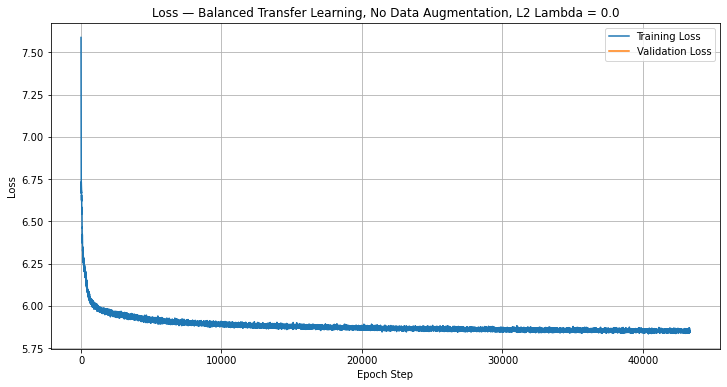

In [25]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

Text(0, 0.5, 'Loss')

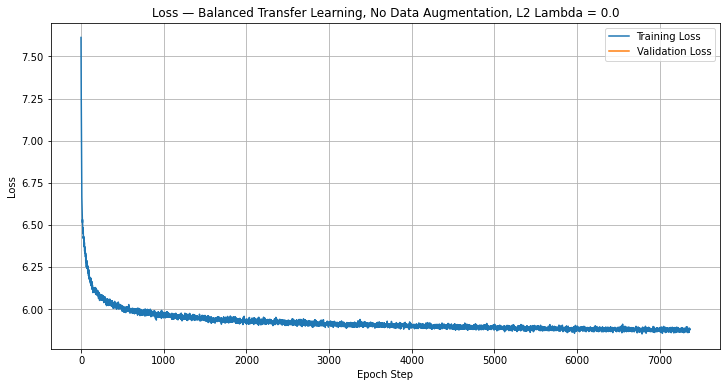

In [27]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [26]:
torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205.pth')

In [28]:
torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth')

## Train classifier (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [34]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [35]:
def transform_null(var):
    return(var)

In [36]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

<IPython.core.display.Javascript object>


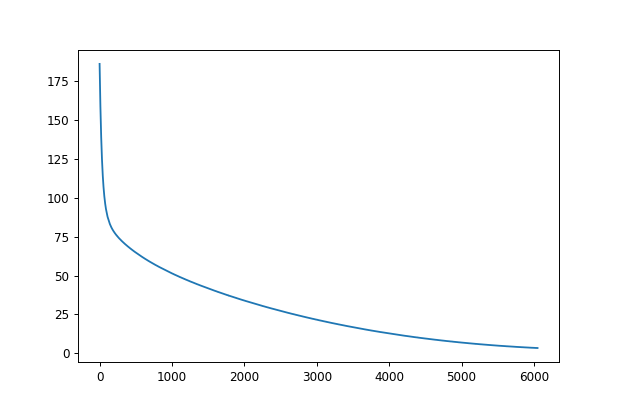

<IPython.core.display.Javascript object>


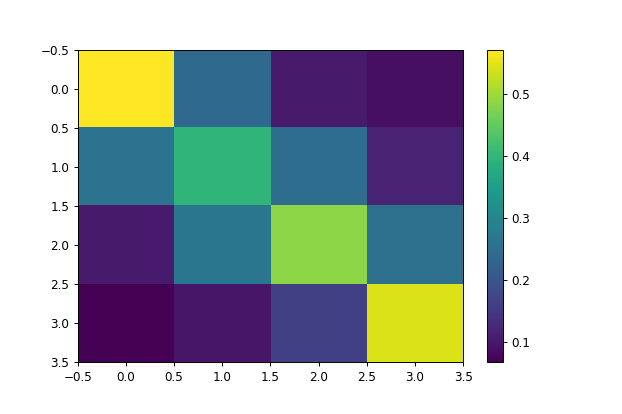

In [235]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

<IPython.core.display.Javascript object>


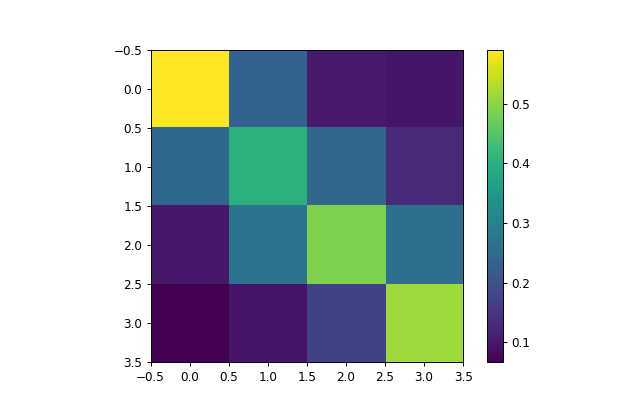

In [236]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Use sklearn to train classifier

In [23]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms)
# scripted_transforms = transforms


In [24]:
dataset_labeled_train = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )

In [27]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [29]:
model.eval()
# model.to(DEVICE)
features_train = model.get_head(model.base_model(torch.as_tensor(torch.stack([data[0][0] for data in dataset_labeled_train], dim=0), device=DEVICE, dtype=torch.float32))).detach().cpu()
features_val   = model.get_head(model.base_model(torch.as_tensor(torch.stack([data[0][0] for data in dataset_labeled_val]  , dim=0), device=DEVICE, dtype=torch.float32))).detach().cpu()

run a sweep of logistic regressions over C (1/L2) parameter

<IPython.core.display.Javascript object>


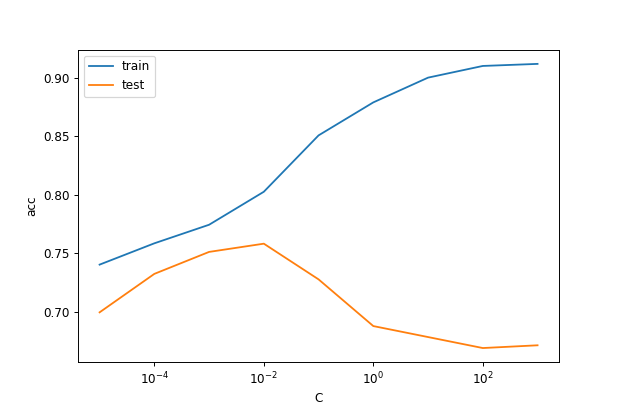

In [68]:
acc_train, acc_val = [], []
C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [73]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=1e-2).fit(features_train, y_labeled_train)

<IPython.core.display.Javascript object>


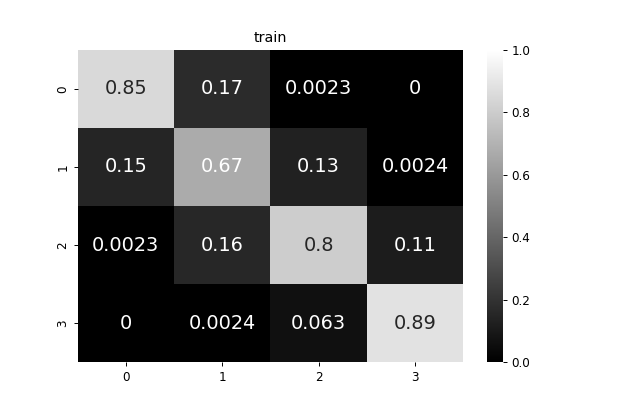

<IPython.core.display.Javascript object>


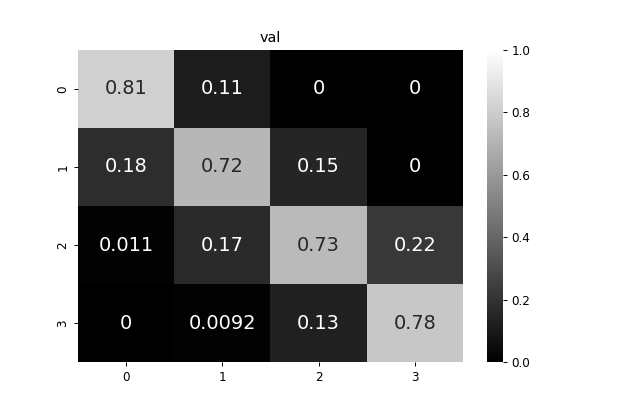

In [75]:
%matplotlib notebook
proba = logreg.predict_proba(features_train)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_train)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_val)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


## Check embeddings

In [76]:
model.eval();
# model.to(DEVICE);

In [77]:
torch.cuda.empty_cache()

In [78]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat[:100000], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat[:100000].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [79]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [80]:
# model.to(DEVICE);

In [81]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [103]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=120.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features_train.cpu())
# features_embedded = tsne.fit_transform(features_embedded[:,:5].cpu())

<IPython.core.display.Javascript object>


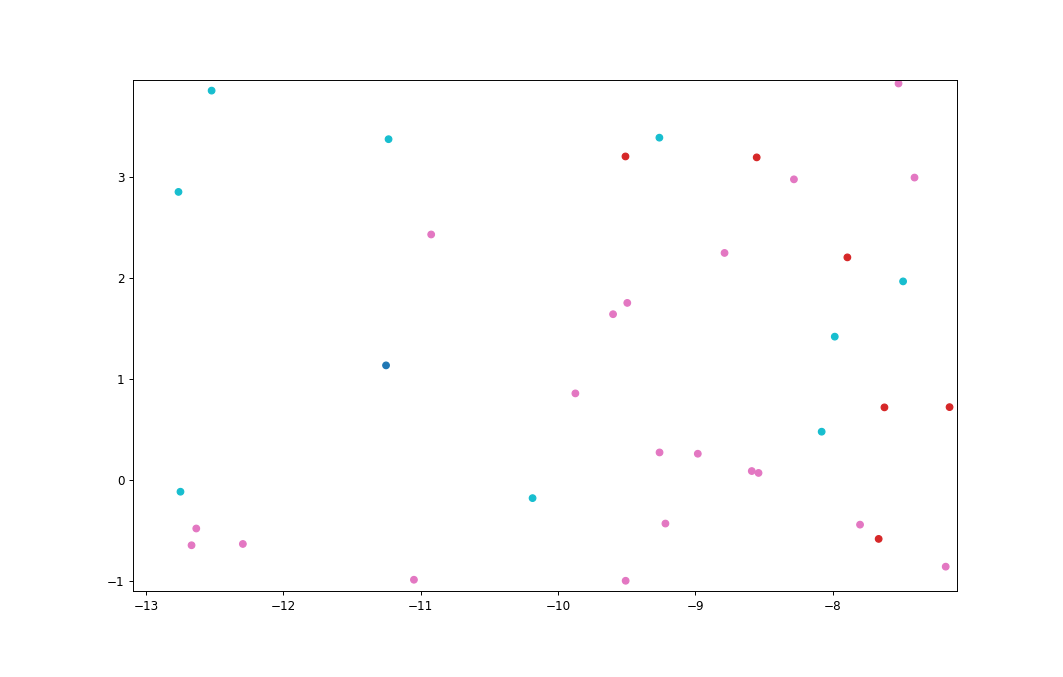

In [104]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=1)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


<IPython.core.display.Javascript object>


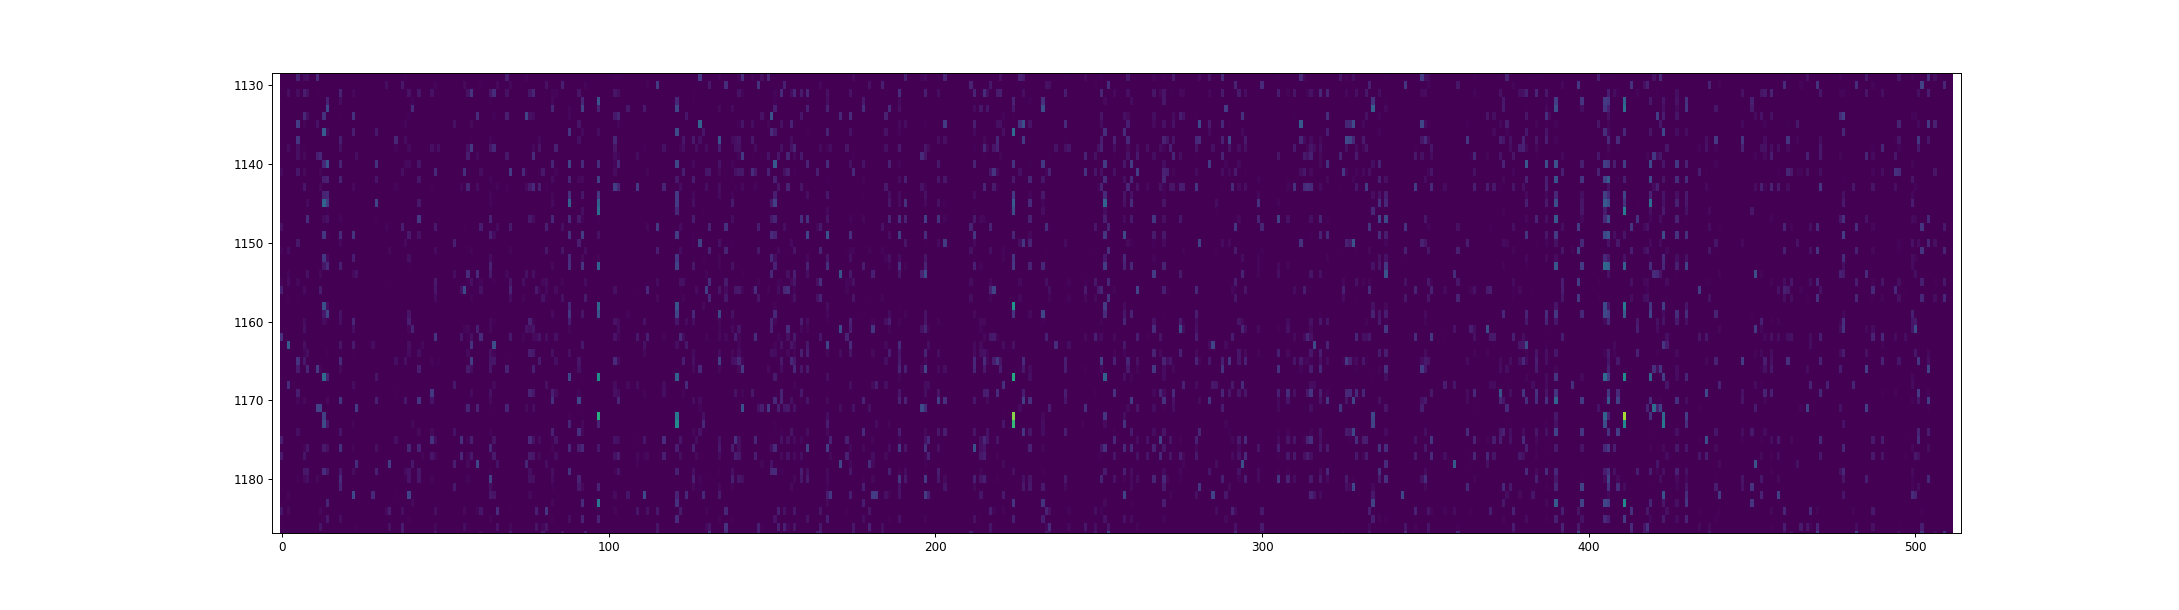

In [83]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

<IPython.core.display.Javascript object>


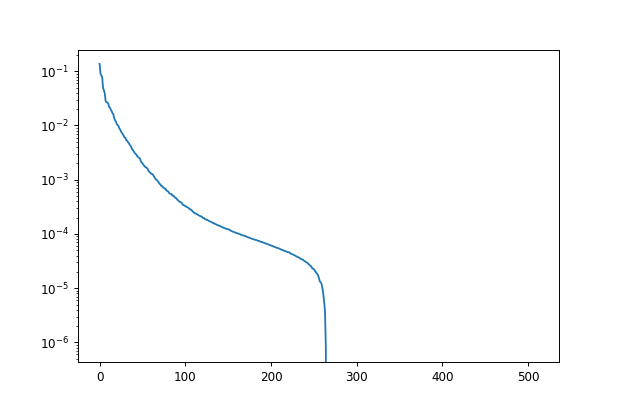

In [236]:
plt.figure()
plt.plot(evr)
plt.yscale('log')

## Check filters

In [247]:
list(model.state_dict().keys())

['base_model.0.weight',
 'base_model.1.weight',
 'base_model.1.bias',
 'base_model.1.running_mean',
 'base_model.1.running_var',
 'base_model.1.num_batches_tracked',
 'base_model.4.0.conv1.weight',
 'base_model.4.0.bn1.weight',
 'base_model.4.0.bn1.bias',
 'base_model.4.0.bn1.running_mean',
 'base_model.4.0.bn1.running_var',
 'base_model.4.0.bn1.num_batches_tracked',
 'base_model.4.0.conv2.weight',
 'base_model.4.0.bn2.weight',
 'base_model.4.0.bn2.bias',
 'base_model.4.0.bn2.running_mean',
 'base_model.4.0.bn2.running_var',
 'base_model.4.0.bn2.num_batches_tracked',
 'base_model.4.1.conv1.weight',
 'base_model.4.1.bn1.weight',
 'base_model.4.1.bn1.bias',
 'base_model.4.1.bn1.running_mean',
 'base_model.4.1.bn1.running_var',
 'base_model.4.1.bn1.num_batches_tracked',
 'base_model.4.1.conv2.weight',
 'base_model.4.1.bn2.weight',
 'base_model.4.1.bn2.bias',
 'base_model.4.1.bn2.running_mean',
 'base_model.4.1.bn2.running_var',
 'base_model.4.1.bn2.num_batches_tracked',
 'base_model.5.0.c

<IPython.core.display.Javascript object>


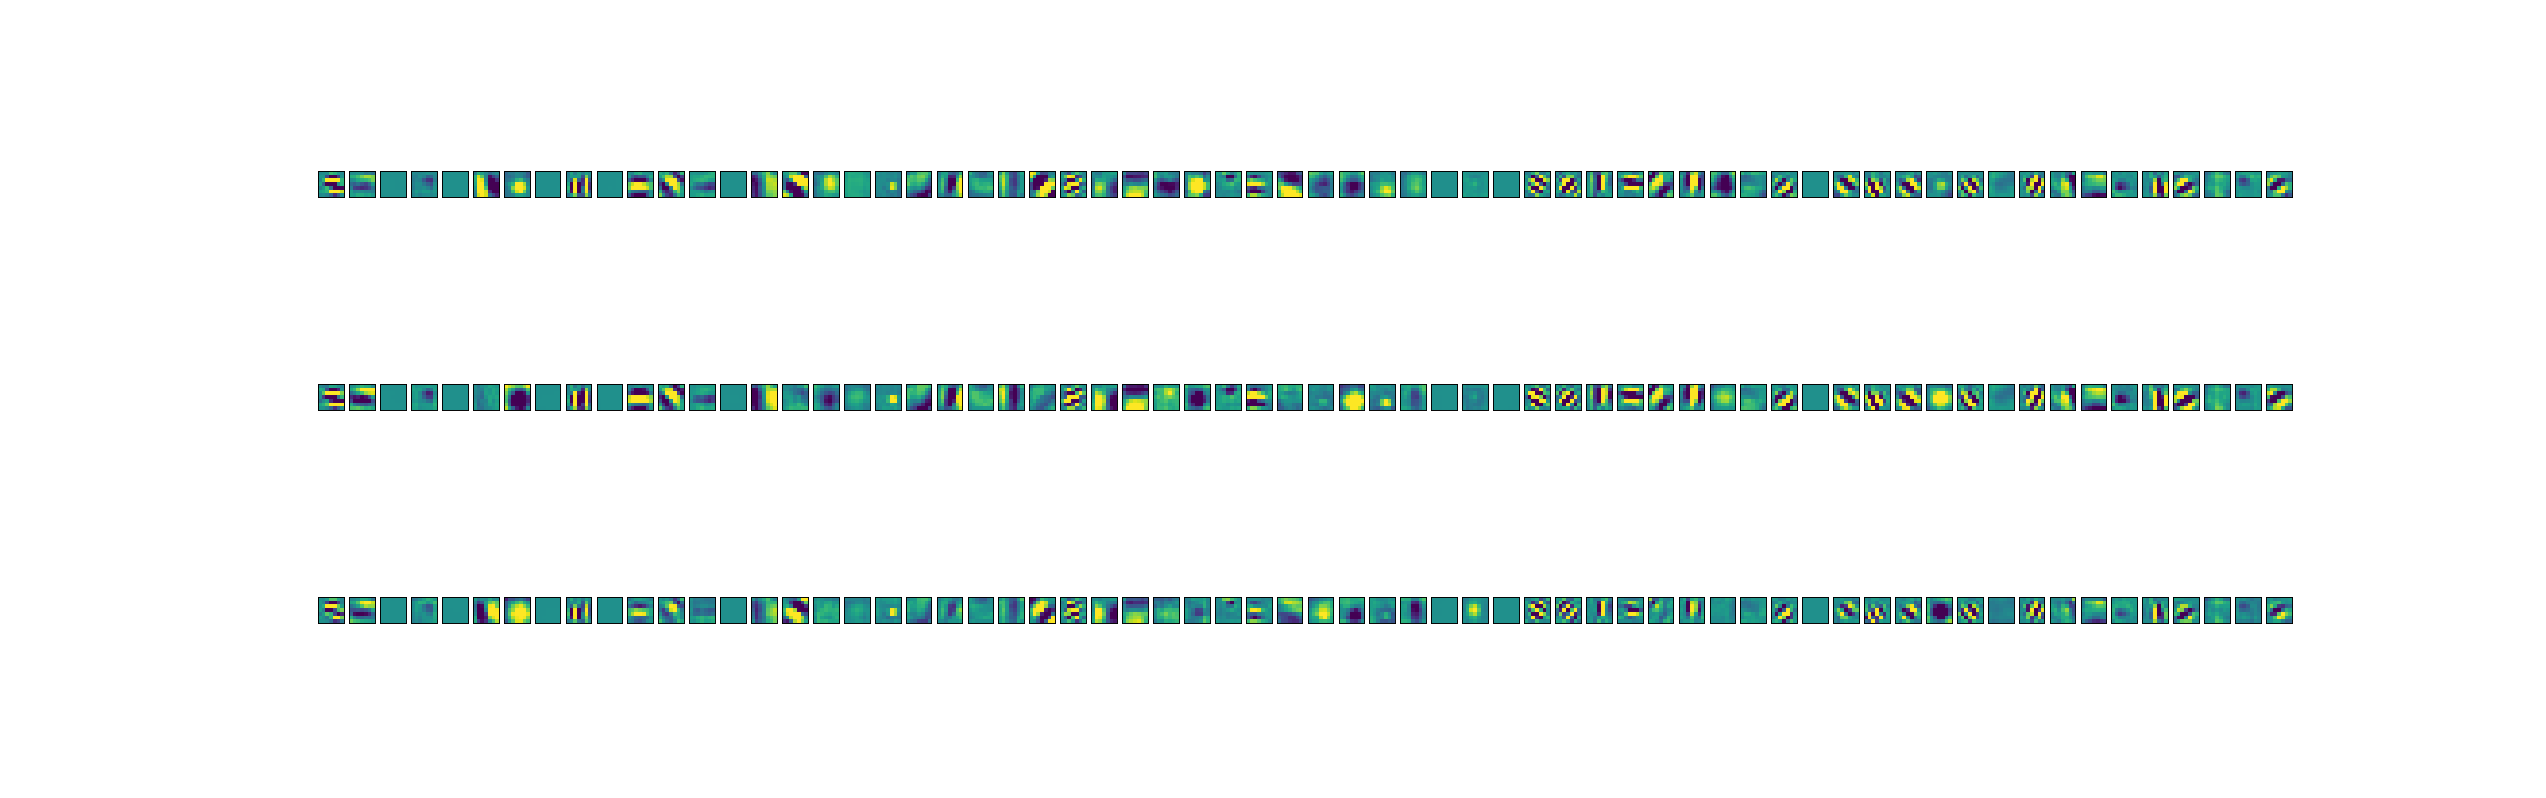

<IPython.core.display.Javascript object>


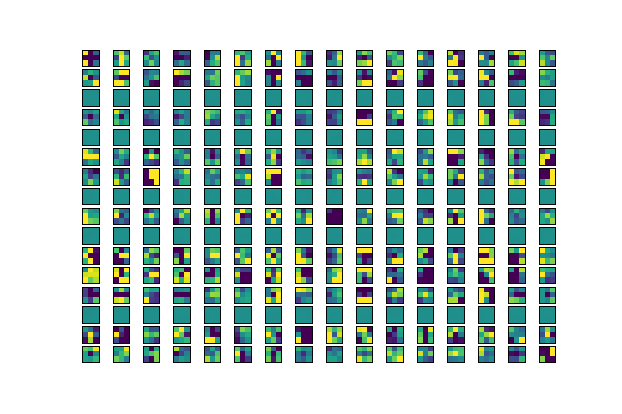

<IPython.core.display.Javascript object>


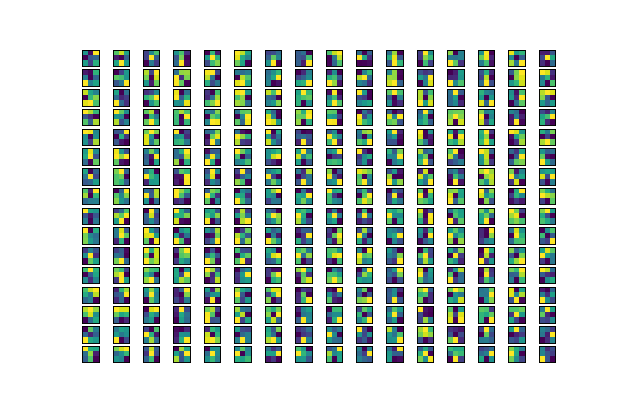

<IPython.core.display.Javascript object>


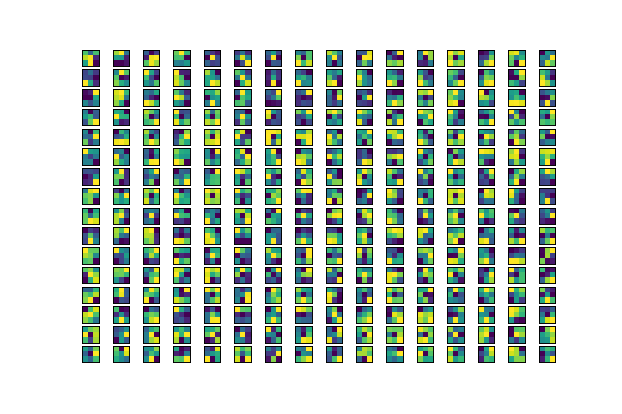

In [97]:
layer_1 = model.state_dict()['base_model.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.4.0.conv1.weight'].cpu()
layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
layer_4 = model.state_dict()['base_model.7.1.conv1.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
